In [2]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
import math

### Bolinger Band 그리기 위한 sigma 계산 helper function

In [3]:
def variance_calculator(series, series_average, win_len):
    sma = win_len
    temp1 = series.subtract(series_average) # a-b
    temp2 = temp1.apply(lambda x: x**2)    # (a-b)^2
    temp3 = temp2.rolling(sma - 1).mean() # sum((a-b)^2) / (sma-1)
    sigma = temp3.apply(lambda x: math.sqrt(x))  # standard deviation
    return sigma

### Quandl 에서 2015.1.1 부터의 매일의 S&P500 선물 지수 및 거래량 정보, 상승 주식 종목수/거래량, 하락 주식 종목수/거래량 download 

In [125]:
# S&P500 future data from "CHRIS/CME_SP1" database
Data1 = quandl.get("CHRIS/CME_SP1", authtoken="U_Gp39gZutpHmaFgC65Y",
                  start_date="2014-12-12")
# number of declining and advancing stocks
declining = quandl.get("URC/NYSE_DEC", authtoken="U_Gp39gZutpHmaFgC65Y",
                       start_date="2014-12-12")
advancing = quandl.get("URC/NYSE_ADV", authtoken="U_Gp39gZutpHmaFgC65Y",
                       start_date="2014-12-12")
adv_vol = quandl.get("URC/NYSE_ADV_VOL", authtoken="U_Gp39gZutpHmaFgC65Y",
                       start_date="2014-12-12")
dec_vol = quandl.get("URC/NYSE_DEC_VOL", authtoken="U_Gp39gZutpHmaFgC65Y",
                       start_date="2014-12-12")

### merge all together

In [126]:
Data = pd.DataFrame()

In [127]:
Data['declining'] = declining['Numbers of Stocks']
Data['advancing'] = advancing['Numbers of Stocks']
Data['dec_vol'] = dec_vol['Numbers of Stocks']
Data['adv_vol'] = adv_vol['Numbers of Stocks']

In [128]:
merged = Data.join(Data1)

In [129]:
merged = merged.fillna(method='ffill')

In [130]:
Data = merged

In [131]:
# find the TRIN value using the number and volume of advancing and declining stocks
AD_ratio = Data['advancing'] / Data['declining']
AD_vol_ratio = adv_vol['Numbers of Stocks'].divide(dec_vol['Numbers of Stocks'])

In [132]:
TRIN = AD_ratio / AD_vol_ratio

In [133]:
Data['TRIN'] = TRIN

### TRIN 은 lopsided 한 속성이 있으므로 log 를 취해 normalize 해 준다

In [134]:
Data['TRIN'] = Data['TRIN'].apply(lambda x: math.log(x))

### S&P500 선물의 closing value (Last) 를 buy/sell order 시의 선물 가격으로 사용하기 위해 새로운 future column 생성하고 완성된 Data 를 csv file 로 저장함

In [135]:
Data['future'] = Data['Last']

In [136]:
Data = Data.reset_index()

In [137]:
Data.to_csv('tempr.csv')

In [138]:
Data = pd.read_csv('tempr.csv', index_col=0)

### Initialize variables which will be used later

In [139]:
sma = 22 # moving average window length
k = 1.2  # Bollinger band 작성시 sigma 의 몇배를 적용할 것인가 하는 상수
l = 1.5    # Bollinger band 에서 sigma 의 몇배에서 stop loss 할 것인지 정하는 상수
pro = 0  # profit
flag = 1 # first transaction 을 하기 위한 flag. 거래는 LBB/UBB crossing over 에서만 시작함
buy_flag = False
sell_flag = False
transaction_start_price = 0
abs_SL = 25 # absolute stop loss 값
mtm = list()
order_details = list()
order = list()  # orders list : BUY/SELL/DO_nothing
profit = list()
buy_sell = list()
stoploss = list()
trade_cause = list()

In [140]:
Data['mAvg'] = Data['TRIN'].rolling(sma).mean()   # moving average of TRIN

In [141]:
Data['TRIN_prev'] = Data['TRIN'].shift(1)

In [142]:
Data.to_csv('tempr.csv')

In [143]:
Data = pd.read_csv('tempr.csv', index_col=0)

In [144]:
sigma = variance_calculator(Data['TRIN'], Data['mAvg'], sma)  # standard deviation

In [145]:
k_sigma = k * sigma
l_sigma = l * sigma

In [146]:
Data['UBB'] = Data['mAvg'].add(k_sigma)       # Upper Bolinger Band
Data['LBB'] = Data['mAvg'].subtract(k_sigma)  # Lower Bolinger Band
Data['USL'] = Data['UBB'].add(l_sigma)        # Upper Stop Loss Band
Data['LSL'] = Data['LBB'].subtract(l_sigma)   # Lower Stop Loss Band
Data['order'] = pd.Series()   # list of orders - BUY/SELL/DO_nothing

In [147]:
s = Data['TRIN'].size           # total number of data points

In [148]:
for i in range(s):
    pro = 0             # will store profit and loss when a trade has been executed
    future_cost = Data['future'][i]          # 'i' 에 해당하는 일자의 선물의 가격
    TRIN = Data['TRIN'][i]
    TRIN_prev = Data['TRIN_prev'][i]
    LBB = Data['LBB'][i]
    UBB = Data['UBB'][i]
    mAvg = Data['mAvg'][i]
    LSL = Data['LSL'][i]
    USL = Data['USL'][i]
    
    UBB_cross = (TRIN > UBB) and (TRIN_prev < UBB)                        # TRIN 이 UBB 를 상향 돌파했는지 check
    LBB_cross = (TRIN < LBB) and (TRIN_prev > LBB)                          # TRIN 이 LBB 를 하향 돌파했는지 check
    mAvg_cross_up = (TRIN > mAvg) and (TRIN_prev < mAvg)            # TRIN 이 mAvg 를 상향 돌파 ?
    mAvg_cross_down = (TRIN < mAvg) and (TRIN_prev > mAvg)        # TRIN 이 mAvg 를 하향 돌파 ?
    USL_cross = (TRIN > USL) and (TRIN_prev < USL)                         # TRIN 이 upper stop loss 를 상향 돌파 ?
    LSL_cross = (TRIN < LSL) and (TRIN_prev > LSL)                          # TRIN 이 lower stop loss 를 하향 돌파 ?
    
    if (UBB_cross and (not buy_flag) and flag == 1):                            # UBB 를 상향 돌파하고 open 된 buy position 이 없음
        flag = 0                                                                                    # position 이 open 되었음 (UBB or LBB cross)
        buy_flag = True                                                                        # open 된 poisiton 이 buy 였음을 표시
        sell_flag = False                                                                       # next trading order 는 sell 만 가능함을 표시
        transaction_start_price = future_cost                                         # 매수가격
        # order type, buy order generated, reason of the trade, 0 - stop loss not triggered, new position is taken
        order_details = [1, "Buy", "UBB crossed", "0", "position taken"]
        
    elif (LBB_cross and (not sell_flag) and flag == 1):                          # LBB 를 하향 돌파하고 open 된 sell position 이 없음
        flag = 0
        buy_flag = False
        sell_flag = True                                                                      
        transaction_start_price = future_cost                                
        order_details = [-1, "Sell", "LBB crossed", "0", "position taken"]
        
    elif (mAvg_cross_up and flag == 0 and (not buy_flag)):                 #  이동평균을 상향돌파하고, position 이 open 되어 있으며,
        flat = 1                                                                                    # next order 는 buy 가 될 수 있음.
        buy_flag = False
        sell_flag = False
        pro = future_cost - transaction_start_price                                 # 이익(손실) 실현
        order_details = [1, "Buy", "mAvg crossed", "0", "position closed"]
        
    elif (LSL_cross and flag == 0 and (not buy_flag)):                          # LSB 를 하향돌파하고 position 이 open 되어 있으며
        flag = 1                                                                                    # next order 는 buy 가 될 수 있음.
        buy_flag = False
        sell_flag = False
        pro = future_cost - transaction_start_price                                 # loss 
        order_details = [1, "Buy", "LSB crossed", "stoploss executed", "position closed"]
        
    elif ((future_cost - transaction_start_price) > abs_SL and flag == 0 and (not buy_flag)): 
        # LSB 를 하향돌파하지는 않았으나  stop loss 보다 손실이 커지고 position 이 open 되어 있으며 next order 는 buy 가 될 수 있음.
        flag = 1                                                                                   
        buy_flag = False
        sell_flag = False
        pro = future_cost - transaction_start_price                                 # loss 
        order_details = [1, "Buy", "LSB crossed", "stoploss executed abs", "position closed"]
        
    elif  (mAvg_cross_down and flag == 0 and (not sell_flag)):             #  이동평균을 하향돌파하고, position 이 open 되어 있으며,
        flat = 1                                                                                    # next order 는 sell 이 될 수 있음.
        buy_flag = False
        sell_flag = False
        pro = -(future_cost - transaction_start_price)                              # 이익(손실)실현
        order_details = [-1, "Sell", "mAvg crossed (h to l)", "0", "position closed"]
        
    elif (USL_cross and flag == 0 and (not sell_flag)):                          # LSB 를 하향돌파하고 position 이 open 되어 있으며
        flag = 1                                                                                    # next order 는 buy 가 될 수 있음.
        buy_flag = False
        sell_flag = False
        pro = -(future_cost - transaction_start_price)                              # loss 
        order_details = [-1, "Sell", "USB crossed", "stoploss executed", "position closed"]
        
    elif ((-future_cost + transaction_start_price) > abs_SL and flag == 0 and (not sell_flag)): 
        # USB 를 상향돌파하지는 않았으나  stop loss 보다 손실이 커지고 position 이 open 되어 있으며 next order 는 sell 이 될 수 있음.
        flag = 1                                                                                   
        buy_flag = False
        sell_flag = False
        pro = -(future_cost - transaction_start_price)                                 # loss 
        order_details = [-1, "Sell", "USB crossed", "stoploss executed abs", "position closed"] 
        
    else:
        if (buy_flag == 0 and sell_flag == 0): tempo = "0"
        else:
            if (buy_flag == 1 and sell_flag == 0): tempo = (Data['future'][i] - transaction_start_price) * 500
            if (buy_flag == 0 and sell_flag == 1): tempo = (-Data['future'][i] + transaction_start_price) * 500
        order_details = [0, "No Trade", "no trade", "0", tempo]
        
    profit.append(pro)
    order.append(order_details[0])
    buy_sell.append(order_details[1])
    trade_cause.append(order_details[2])
    stoploss.append(order_details[3])
    mtm.append(order_details[4])

In [149]:
Data['placed_order'] = pd.Series(order)
Data['cost'] = -(Data['placed_order'].multiply(Data['future'])) * 500
Data['out']  = Data['cost'].cumsum()
Data['buy_sell'] = pd.Series(buy_sell)
Data['profit'] = -pd.Series(profit) * 500
Data['stoploss'] = pd.Series(stoploss)
Data['trade_cause'] = pd.Series(trade_cause)
Data['mtm'] = pd.Series(mtm)

In [150]:
output = pd.DataFrame() #....final output to be stored in excel file
output['date'] = Data['Date']
output['Close'] = Data['future']
output['TRIN'] = Data['TRIN']
output['mAvg'] = Data['mAvg']
output['UBB']  = Data['UBB']
output['LBB']  = Data['LBB']
output['placed_order'] = Data['placed_order']
output['buy_sell'] = Data['buy_sell']
output['trade_cause'] =  Data['trade_cause']
output['PnL'] = Data['profit']
output['mtm'] = Data['mtm']
output['stoploss'] = Data['stoploss']
output['Cash Account'] = Data['out']
output.to_excel('TRIN_SL_output.xlsx', sheet_name='Sheet1')

In [151]:
Data['out']

0            -0.0
1            -0.0
2            -0.0
3            -0.0
4            -0.0
5            -0.0
6            -0.0
7            -0.0
8            -0.0
9            -0.0
10           -0.0
11           -0.0
12           -0.0
13           -0.0
14           -0.0
15           -0.0
16           -0.0
17           -0.0
18           -0.0
19           -0.0
20           -0.0
21           -0.0
22           -0.0
23           -0.0
24           -0.0
25           -0.0
26           -0.0
27           -0.0
28           -0.0
29           -0.0
          ...    
895   -21732700.0
896   -21732700.0
897   -21732700.0
898   -23096200.0
899   -23096200.0
900   -21726850.0
901   -23108500.0
902   -23108500.0
903   -23108500.0
904   -24495250.0
905   -23095850.0
906   -24497600.0
907   -23099100.0
908   -24504600.0
909   -24504600.0
910   -25907100.0
911   -25907100.0
912   -24500950.0
913   -24500950.0
914   -25921700.0
915   -27342950.0
916   -27342950.0
917   -27342950.0
918   -27342950.0
919   -273

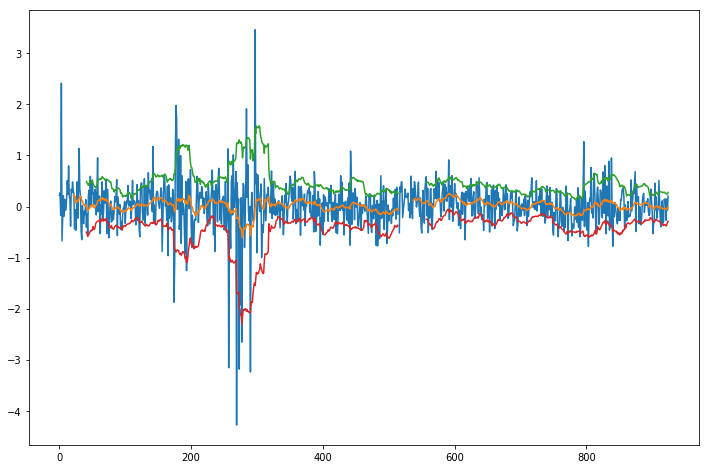

In [152]:
plt.figure(figsize=(12,8))
plt.plot(Data['TRIN'])
plt.plot(Data['mAvg'])
plt.plot(Data['UBB'])
plt.plot(Data['LBB'])

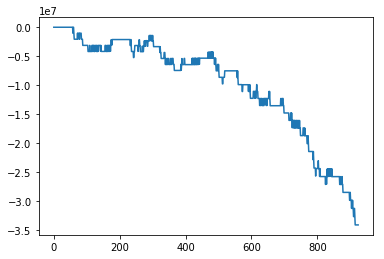

In [87]:
plt.plot(Data['out'])